In [2]:
!pip install -q transformers peft datasets accelerate evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset, concatenate_datasets, ClassLabel, Features, Value, Image
import numpy as np

med_dataset_id = "flaviagiammarino/vqa-rad"
norm_dataset_id = "RIW/small-coco"
print("Загрузка датасетов с Hugging Face...")

ds_med = load_dataset(med_dataset_id, split="train[:600]")
ds_med = ds_med.select_columns(["image"])
# Добавляем метку 1 (Medical)
ds_med = ds_med.add_column("label", [1] * len(ds_med))

ds_norm = load_dataset("RIW/small-coco", split="train")
ds_norm = ds_norm.shuffle(seed=42).select(range(600))
ds_norm = ds_norm.select_columns(["image"])

# Добавляем метку 0 (Normal)
ds_norm = ds_norm.add_column("label", [0] * len(ds_norm))

print(f"Загружено: Medical={len(ds_med)}, Normal={len(ds_norm)}")

dataset_full = concatenate_datasets([ds_med, ds_norm])

# Перемешиваем
dataset_full = dataset_full.shuffle(seed=42)

# Разбиваем на train и test
dataset = dataset_full.train_test_split(test_size=0.15)

# Создаем маппинг классов вручную
labels = ["Normal", "Medical"]
label2id = {"Normal": "0", "Medical": "1"}
id2label = {"0": "Normal", "1": "Medical"}

print("Датасет собран и перемешан!")
print(dataset)

# --- ПОДГОТОВКА ДАННЫХ ДЛЯ VIT ---

from transformers import ViTImageProcessor
from torchvision.transforms import (
    Compose, Normalize, Resize, ToTensor
)

model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)


Загрузка датасетов с Hugging Face...


README.md:   0%|          | 0.00/836 [00:00<?, ?B/s]

data/train-00000-of-00004-076100b559a1d8(…):   0%|          | 0.00/62.8M [00:00<?, ?B/s]

data/train-00001-of-00004-eb0de0595e4e25(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

data/train-00002-of-00004-4db5389cd70cd0(…):   0%|          | 0.00/296M [00:00<?, ?B/s]

data/train-00003-of-00004-3e1a91c6f2615c(…):   0%|          | 0.00/141M [00:00<?, ?B/s]

data/validation-00000-of-00004-4e632296b(…):   0%|          | 0.00/64.9M [00:00<?, ?B/s]

data/validation-00001-of-00004-abf1bae7c(…):   0%|          | 0.00/153M [00:00<?, ?B/s]

data/validation-00002-of-00004-ea5c8c736(…):   0%|          | 0.00/292M [00:00<?, ?B/s]

data/validation-00003-of-00004-df77f0ca4(…):   0%|          | 0.00/146M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9890 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9893 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/600 [00:00<?, ? examples/s]

Загружено: Medical=600, Normal=600
Датасет собран и перемешан!
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1020
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 180
    })
})


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Данные готовы к передаче в Trainer.


In [18]:
def transforms(examples):
    # .convert("L") делает ЧБ
    # .convert("RGB") возвращает 3 канала, но картинка остается визуально серой (R=G=B)
    examples["pixel_values"] = [
        _transforms(img.convert("L").convert("RGB")) for img in examples["image"]
    ]
    del examples["image"]
    return examples

_transforms = Compose([
    Resize(size),
    ToTensor(),
    normalize,
])

# Применяем трансформации
prepared_ds = dataset.with_transform(transforms)

print("Данные готовы к передаче в Trainer.")

Данные готовы к передаче в Trainer.


In [19]:
import torch
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import evaluate

# 1. Загрузка базовой модели
# Мы используем ту же модель, что и в image_processor
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id={"Normal": 0, "Medical": 1}, # Приводим id к int
    ignore_mismatched_sizes=True # Важно, так как мы меняем выходной слой (classifier)
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:

# 2. Настройка LoRA
# Для ViT обычно адаптируют слои query и value в блоках внимания.
# modules_to_save=["classifier"] означает, что мы будем полностью обучать
# классификационную голову (так как она новая и инициализирована случайно),
# а остальные слои заморозим и добавим к ним адаптеры.
peft_config = LoraConfig(
    r=16,                   # Ранг адаптеров (чем больше, тем больше параметров)
    lora_alpha=16,          # Масштабирующий коэффициент
    target_modules=["query", "value"], # Основные модули внимания в ViT
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"], # Обязательно обучаем новый выходной слой целиком!
)

# Оборачиваем модель в PEFT
model = get_peft_model(model, peft_config)

# Проверяем количество обучаемых параметров (должно быть < 5% от всей модели)
model.print_trainable_parameters()

trainable params: 591,362 || all params: 86,391,556 || trainable%: 0.6845


In [21]:

# 3. Настройка метрик
metric = evaluate.load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

# 4. Data Collator (сборщик батчей)
# Так как мы используем with_transform, нам нужна функция для упаковки тензоров в батч
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

# 5. Аргументы обучения
training_args = TrainingArguments(
    output_dir="./vit-med-lora",
    per_device_train_batch_size=32, # Можно увеличить, т.к. LoRA потребляет меньше памяти
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,             # LoRA часто требует чуть больше эпох или выше learning rate
    learning_rate=5e-4,             # LR для LoRA обычно выше (например, 1e-3 или 5e-4)
    logging_steps=10,
    load_best_model_at_end=True,
    remove_unused_columns=False,    # Важно для корректной работы с transforms
    save_total_limit=2,
    report_to="none"                # Отключаем wandb/tensorboard для простоты примера
)

In [22]:
# 6. Инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/tmp/ipython-input-3425496785.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
# 7. Запуск обучения
print("Начинаем обучение с LoRA...")
trainer.train()

Начинаем обучение с LoRA...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.175400,0.054123,1.000000
2,0.009000,0.006418,1.000000
3,0.004500,0.004002,1.000000
4,0.003600,0.003321,1.000000
5,0.003100,0.003131,1.000000


TrainOutput(global_step=160, training_loss=0.0811977279256098, metrics={'train_runtime': 242.076, 'train_samples_per_second': 21.068, 'train_steps_per_second': 0.661, 'total_flos': 3.979330531319808e+17, 'train_loss': 0.0811977279256098, 'epoch': 5.0})

In [24]:
# 8. Сохранение адаптеров
trainer.save_model("med_clf")
print("Обучение завершено. Модель сохранена в 'med_clf'")

Обучение завершено. Модель сохранена в 'med_clf'


In [25]:
from peft import PeftModel, PeftConfig

# 1. Загружаем базовую модель
base_model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
    id2label=id2label,
    label2id={"Normal": 0, "Medical": 1},
    ignore_mismatched_sizes=True
)

# 2. Накладываем обученные веса LoRA
model_inference = PeftModel.from_pretrained(base_model, "med_clf")
model_inference.eval()

# Далее можно предсказывать как обычно

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModel(
  (base_model): LoraModel(
    (model): ViTForImageClassification(
      (vit): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTAttention(
                (attention): ViTSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      

ID примера: 143
------------------------------
Истинный класс: Medical (id: 1)
Предсказание:   Medical (id: 1)
Уверенность:    99.62%


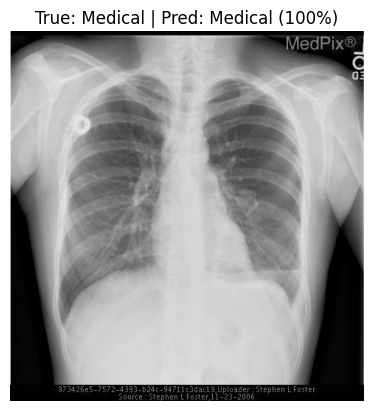

In [48]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()

device = next(model.parameters()).device

idx = random.randint(0, len(dataset["test"]) - 1)
sample = dataset["test"][idx]

image = sample["image"]
true_label_id = sample["label"]

image = image.convert("L").convert("RGB") # to Black-White

inputs = image_processor(image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

    probs = F.softmax(logits, dim=-1)
    predicted_class_id = probs.argmax().item()
    confidence = probs[0][predicted_class_id].item()

label_map = {0: "Normal", 1: "Medical"}

true_label_name = label_map[true_label_id]
pred_label_name = label_map[predicted_class_id]

print(f"ID примера: {idx}")
print("-" * 30)
print(f"Истинный класс: {true_label_name} (id: {true_label_id})")
print(f"Предсказание:   {pred_label_name} (id: {predicted_class_id})")
print(f"Уверенность:    {confidence:.2%}")

if image.mode != "RGB":
    image = image.convert("RGB")

plt.imshow(image)
plt.axis("off")
plt.title(f"True: {true_label_name} | Pred: {pred_label_name} ({confidence:.0%})")
plt.show()


In [43]:
import requests
